In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [13]:
image = cv2.imread('spoon_obj.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [14]:
image.shape

(720, 1280, 3)

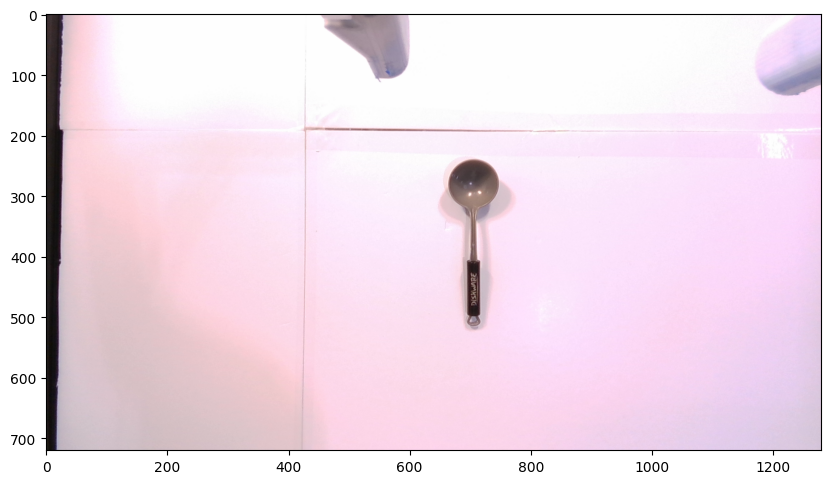

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [7]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/arvind/LLM_Tool/SAM/sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
masks = mask_generator.generate(image)

In [9]:
print(len(masks))
print(masks[0].keys())

7
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [10]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0

    m = sorted_anns[1]['segmentation']
    color_mask = [0, 0, 0]
    img[m] = np.concatenate([color_mask, [1]])

    """
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        print(color_mask)
        img[m] = color_mask
    """
    ax.imshow(img)

In [11]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.zeros((sorted_anns[1]['segmentation'].shape[0], sorted_anns[1]['segmentation'].shape[1], 4))  # Initialize with zeros for full transparency
    m = sorted_anns[1]['segmentation']
    color_mask = [0, 0, 0]
    img[m] = np.concatenate([color_mask, [1]])  # Set alpha to 1 for full opacity of the mask

    ax.imshow(img)
    plt.show()

In [23]:
# grounding dino
sys.path.append('/home/arvind/LLM_Tool/grasping/grasping/os_tog/GroundingDINO')
from groundingdino.util.inference import load_model, load_image, predict, annotate
from torchvision.ops import box_convert
import supervision as sv

def get_bbox(image_path:str,
             TEXT_PROMPT:str,
             BOX_TRESHOLD = 0.35,
            TEXT_TRESHOLD = 0.25) -> list:
    """
    Based on the image and the prompt, this function outputs the bounding box that surrounds the target in the image

    Args:
    image_path : Path to the broken image
    TEXT_PROMPT : What to point to in the image given
    BOX_THRESHOLD
    TEXT_THRESHOLD
    """
    current_dir = os.path.dirname(os.path.abspath(''))
    sys.path.append(current_dir)
    model = load_model("GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", "GroundingDINO/weights/groundingdino_swint_ogc.pth")
    image_source, image = load_image(image_path)
    print(image.shape)

    boxes, logits, phrases = predict(
        model=model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    h, w, _ = image_source.shape
    boxes = boxes * torch.Tensor([w, h, w, h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    detections = sv.Detections(xyxy=xyxy)
    return detections, annotated_frame


In [29]:
import os

def init_sam():
    """
    -> Initializes the model that is used for SAM
    -> If you want to use a different model, you can change it in this function
    """
    sam_checkpoint = "/home/arvind/LLM_Tool/SAM/sam_vit_b_01ec64.pth"
    model_type = "vit_b"
    device = 'cuda'
    return sam_checkpoint, model_type, device

def get_mask(image,
             box_coordinates: list, 
             MASK_image_path:str):

    """
    Based on the image and the bounding box, this function generates a mask of the main object.
    """

    sam_checkpoint, model_type, device = init_sam()
    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    input_boxes = np.array(box_coordinates)
    predictor.set_image(image)
    masks, _, _ = predictor.predict(
    point_coords = None,
    point_labels = None, 
    box = input_boxes,
    multimask_output = False,
)   
    mask = masks.squeeze()
    mask = mask.astype(np.float32)*255  # Assuming your original mask is of float32 type
    mask_uint8 = mask.astype(np.uint8)
    _, mask_uint8 = cv2.threshold(mask_uint8, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(MASK_image_path, mask_uint8)
    # print(f"INFO:: Mask is successfully saved at {MASK_image_path}")
    return masks

detections, annotated_frame = get_bbox('spoon.png', 'spoon', BOX_TRESHOLD = 0.6, TEXT_TRESHOLD = 0.5)
boxes = detections.xyxy
bbox = boxes[0]
input_img = cv2.imread('spoon.png')
get_mask(input_img,
         bbox,
         'spoon_object.png')




final text_encoder_type: bert-base-uncased
torch.Size([3, 804, 800])


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [19]:
# plt.figure(figsize=(20,20))
# plt.imshow(image)
# mask = masks[0]['segmentation'].shape



# Scale the mask to 255 for better visualization

# Plot the original image using matplotlib
# plt.figure(figsize=(20, 20))
# plt.imshow(image)
# plt.title("Original Image")
# plt.show()

# Plot the mask using OpenCV



mask = masks[3]['segmentation'].astype(np.uint8)
mask *= 255
print(mask.shape)
image = cv2.resize(image, (394,396))
mask = cv2.resize(mask, (394,396))

cv2.imwrite('spoon.png', np.array(image))
cv2.imwrite('spoon_object.png', np.array(mask))


(280, 296)


True

In [1]:
def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	plt.imshow(crop_img)
	return crop_img

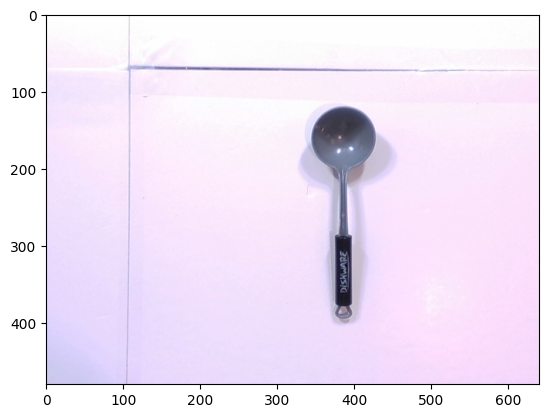

In [9]:
import cv2
img = cv2.imread('spoon_obj.png')
m = center_crop(img, [640,480])
plt.imshow(m)

In [10]:
scene_img = cv2.cvtColor(m, cv2.COLOR_BGR2RGB)
scene_img.shape

(480, 640, 3)